### Fourier Transform 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from numpy import fft 
import random
import os 


## Search method practice

### 1. Symbol-to-Symbol Detection

[ 1.+1.j  1.-1.j  1.-1.j  1.+1.j  1.-1.j -1.-1.j  1.+1.j  1.+1.j  1.+1.j
 -1.+1.j]
0 (0.7024941855544932+1.0357420328327678j)
1 (0.7345987366501474-0.40642340942879485j)
2 (0.22193115683559325-0.5548406931453699j)
3 (1.2881851999511242+1.2265942306355093j)
4 (1.0217370929680125-0.6185096503617826j)
5 (-0.0469937711324231-0.46878939585538004j)
6 (0.7054855907175963+0.33591439819833296j)
7 (0.43331112120280485+1.084634732269889j)
8 (0.45782148183501764+0.4079474812529895j)
9 (-0.7394590730515874+1.1420304012951545j)


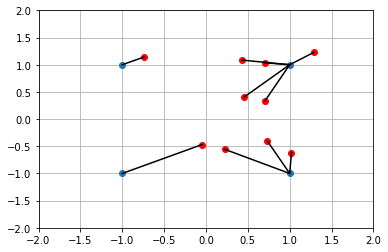

In [3]:
x_r = np.random.randn(10)
x_i = np.random.randn(10) 
x = x_r + 1j * x_i 
cp_r = []

cpoints = np.array([
    -1-1j,
    -1+1j, 
    1+1j,
    1-1j,
])
plt.plot(cpoints.real, cpoints.imag, 'o')
plt.plot(x_r, x_i, 'or')

compare = np.abs(x - cpoints.reshape(-1, 1))
dets = np.array([cpoints[i] for i in np.argmin(compare, axis=0)])
print(dets)

for i, cp in enumerate(x):
    print(i, cp) 
    plt.plot([dets[i].real, cp.real], [dets[i].imag, cp.imag], 'k-')

plt.grid() 
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()


In [12]:
c = 2
x_estimated = x
x_detected = dets 
x_exact = cpoints.reshape(-1, 1)
x_estimated, x_detected, x_exact 

(array([ 1.46707364-0.17529495j,  0.67826399+0.66004183j,
        -1.15626819+0.1984927j , -0.76018229-0.85921641j,
        -0.89683452+1.04548489j, -0.5997528 +0.23669945j,
         2.40502155+0.85174651j, -0.79211292+0.7745666j ,
         1.30878128-0.41610247j, -2.00853931+0.21626987j]),
 array([ 1.-1.j,  1.+1.j, -1.+1.j, -1.-1.j, -1.+1.j, -1.+1.j,  1.+1.j,
        -1.+1.j,  1.-1.j, -1.+1.j]),
 array([[-1.-1.j],
        [-1.+1.j],
        [ 1.+1.j],
        [ 1.-1.j]]))

In [13]:
nominator = np.abs(x_estimated - x_exact)
denominator = np.abs(x_estimated - x_detected)

In [14]:
print(nominator)
print(denominator)
condition = nominator / denominator < c

[[2.60126715 2.36057385 1.20863746 0.27808731 2.04808485 1.29985513
  3.87596915 1.78670189 2.38147167 1.58002023]
 [2.73272219 1.71234972 0.81659886 1.87461948 0.11274746 0.86187327
  3.40824747 0.30665495 2.70847138 1.27725661]
 [1.26470392 0.46806583 2.30041441 2.56025924 1.8973798  1.77252271
  1.41282152 1.80623612 1.44937644 3.10894543]
 [0.94778489 1.69093257 2.46695709 1.76580342 2.78962177 2.02203723
  2.32444632 2.52205379 0.66051662 3.24509186]]
[0.94778489 0.46806583 0.81659886 0.27808731 0.11274746 0.86187327
 1.41282152 0.30665495 0.66051662 1.27725661]


In [15]:
# search nML 

print(np.sum(condition.T, axis=1))
nnset = np.array(np.nonzero(condition.T))
# np.array([cpoints[i] for i in np.nonzero(condition.T)[1]])

nn = [[] for _ in range(10)]
for k, m in nnset.T:

    nn[k].append(m) 
print(nn)
new = []
for n in nn:
    new.append(list(np.take(cpoints, n)))
new

[2 1 2 1 1 2 2 1 1 2]
[[2, 3], [2], [0, 1], [0], [1], [0, 1], [2, 3], [1], [3], [0, 1]]


[[(1+1j), (1-1j)],
 [(1+1j)],
 [(-1-1j), (-1+1j)],
 [(-1-1j)],
 [(-1+1j)],
 [(-1-1j), (-1+1j)],
 [(1+1j), (1-1j)],
 [(-1+1j)],
 [(1-1j)],
 [(-1-1j), (-1+1j)]]

## MIMO Receiver with 1-bit-ADC (Linear Receiver) for 1 timestep

In [37]:
K = 2
N = 16
M = 4 


def make_symbol_space(K, M, cp):
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    symbol_space = np.hstack((symbol_space.real, symbol_space.imag))
    return symbol_space 

def comp2re(H, x, z, y):
    x_re = np.vstack((x.real, x.imag))
    z_re = np.vstack((z.real, x.imag))
    y_re = np.vstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

# symbols for 1-timeslot 
x = np.random.randint(0, M, size=K).reshape(-1, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(N, K) + 1j * np.random.randn(N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(N, 1) + 1j * np.random.randn(N, 1))

r = np.matmul(H, x) + z 

# 1-bit ADC 
y = np.sign(r.real) + 1j * np.sign(r.imag) 

H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

# # relaxed linear receiver 
# W_zf = np.linalg.pinv(H_re)
# W_MMSE = np.matmul((H_re.conjugate()).T, H_re) + np.eye(2 * K) 
# W_MMSE = np.linalg.inv(W_MMSE) 
# W_MMSE = np.matmul(W_MMSE, (H_re.conjugate()).T)

# # Relaxed estimation of x  
# x_tilde_zf = np.matmul(W_zf, y) 
# x_tilde_mmse = np.matmul(W_MMSE, y) 


# # real to complex representation to detect symbol
# x_tilde_zf = x_tilde_zf[:K] + 1j * x_tilde_zf[K:]
# x_tilde_mmse = x_tilde_mmse[:K] + 1j * x_tilde_mmse[K:]

# # detection within each users (symbol-by-symbol)
# compare = np.abs(x_tilde_zf - constellation_points)
# det_by_idx = np.argmin(compare, axis=1) 
# x_hat_zf = np.take(constellation_points, det_by_idx).reshape(x_tilde_zf.shape)

# compare = np.abs(x_tilde_mmse - constellation_points)
# det_by_idx = np.argmin(compare, axis=1) 
# x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

# # Compare 
# np.isclose(x, x_hat_zf), np.isclose(x, x_hat_mmse)





In [38]:
symbol_space

array([[-0.70710678, -0.70710678, -0.70710678, -0.70710678],
       [-0.70710678, -0.70710678, -0.70710678,  0.70710678],
       [-0.70710678,  0.70710678, -0.70710678, -0.70710678],
       [-0.70710678,  0.70710678, -0.70710678,  0.70710678],
       [-0.70710678, -0.70710678,  0.70710678, -0.70710678],
       [-0.70710678, -0.70710678,  0.70710678,  0.70710678],
       [-0.70710678,  0.70710678,  0.70710678, -0.70710678],
       [-0.70710678,  0.70710678,  0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678, -0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678, -0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678, -0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678, -0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678,  0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678,  0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678,  0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678,  0.70710678,  0.70710678]])

## MIMO receiver with 1-bit-ADC (Linear Receiver) with N time transmission 

snr:  0 ser (zf):  0.01959999999999995      |     ser(mmse):  0.020050000000000012
snr:  5 ser (zf):  0.002850000000000019      |     ser(mmse):  0.0034999999999999476
snr:  10 ser (zf):  0.0008000000000000229      |     ser(mmse):  0.0004999999999999449
snr:  15 ser (zf):  0.0007500000000000284      |     ser(mmse):  0.0007500000000000284
snr:  20 ser (zf):  0.0006000000000000449      |     ser(mmse):  0.0006000000000000449
snr:  25 ser (zf):  0.00034999999999996145      |     ser(mmse):  0.00039999999999995595


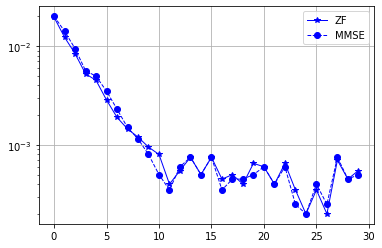

In [7]:
from matplotlib.markers import MarkerStyle


K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = int(1e4) # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 
sers = []
sers_mmse = []
for snr in range(SNR_max):
    # symbols for T timeslots
    x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
    x = np.take(constellation_points, x)

    # Channel 
    H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
    z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

    r = np.matmul(H, x) + (10**(-snr/20)) * z 

    # Complex to real representation 
    H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

    # 1-bit ADC 
    y = np.sign(r_re) 
    y = y[:, :N, :] + 1j*y[:, N:, :]

    # relaxed linear receiver 
    W_zf = np.linalg.pinv(H)
    W_mmse = np.matmul((H.conjugate()).transpose((0, 2, 1)), H) + (10**(-snr/20))*((np.eye(K)+1j*np.eye(K)) * np.ones((T, K, K)))
    W_mmse = np.linalg.inv(W_mmse)
    W_mmse = np.matmul(W_mmse, (H.conjugate()).transpose((0, 2, 1)))

    # Relaxed estimation of x  
    x_tilde = np.matmul(W_zf, y)
    x_tilde_mmse = np.matmul(W_mmse, y)
        

    # detection within each users (symbol-by-symbol)
    compare = np.abs(x_tilde - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1) 
    x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)

    compare = np.abs(x_tilde_mmse - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1)
    x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

    # Compare 
    ser = 1-np.sum(np.isclose(x, x_hat)) / (T * K)
    ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T*K)

    if snr % 5 == 0:
        print("snr: ", snr, "ser (zf): ", ser, "     |     ser(mmse): ", ser_mmse)
    sers.append(ser)
    sers_mmse.append(ser_mmse)



plt.figure()
plt.semilogy(sers, '-b*', linewidth=1, label='ZF') 
plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.grid() 
plt.legend()
plt.show()


## MIMO receiver with 1-bit-ADC (Linear Receiver) with N time transmission 
### monte-carlo simulation

____________________________________________________________________________________________________
trial :  0
snr:  -5 ser(zf):  0.11345000000000005    |   ser(mmse):  0.12109999999999999
snr:  0 ser(zf):  0.017199999999999993    |   ser(mmse):  0.018299999999999983
snr:  5 ser(zf):  0.0022999999999999687    |   ser(mmse):  0.0021499999999999853
snr:  10 ser(zf):  0.0009500000000000064    |   ser(mmse):  0.0010000000000000009
snr:  15 ser(zf):  0.00029999999999996696    |   ser(mmse):  0.00029999999999996696
snr:  20 ser(zf):  0.00039999999999995595    |   ser(mmse):  0.00034999999999996145
snr:  25 ser(zf):  0.00024999999999997247    |   ser(mmse):  0.00024999999999997247
____________________________________________________________________________________________________
trial :  1
snr:  -5 ser(zf):  0.11199999999999999    |   ser(mmse):  0.11809999999999998
snr:  0 ser(zf):  0.01795000000000002    |   ser(mmse):  0.01959999999999995
snr:  5 ser(zf):  0.0029000000000000137    |   se

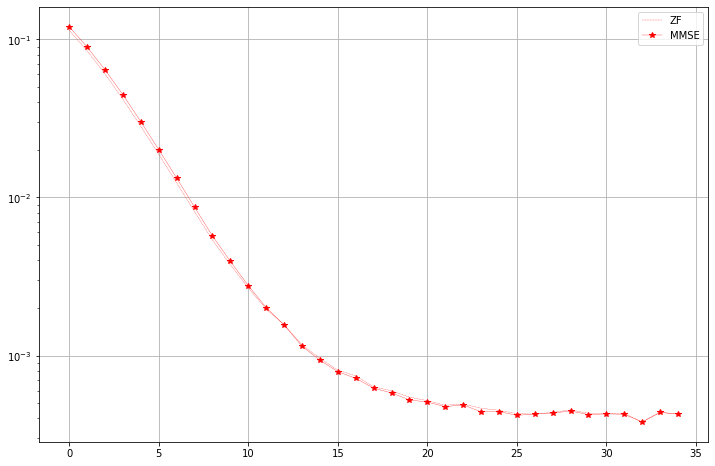

In [8]:
K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = int(1e4) # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

sers_avg_zf = np.zeros((SNR_max+5))
sers_avg_mmse = np.zeros((SNR_max+5))
trials = 100
for t in range(trials):
    sers_zf = []
    sers_mmse = []
    print("_" * 100) 
    print("trial : ", t)
    for snr in range(-5, SNR_max):
        # symbols for T timeslots
        x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
        x = np.take(constellation_points, x)

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z 

        # Complex to real representation 
        H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

        # 1-bit ADC 
        y = np.sign(r_re)
        y = y[:, :N, :] + 1j * y[:, N:, :] 

        # relaxed linear receiver 
        W_zf = np.linalg.pinv(H)
        W_MMSE = np.matmul((H.conjugate()).transpose(0, 2, 1), H) + (10 ** (-snr/20)) * ((np.eye(K) + 1j * np.eye(K)) * np.ones(shape=(T, K, K)))
        W_MMSE = np.linalg.inv(W_MMSE) 
        W_MMSE = np.matmul(W_MMSE, (H.conjugate()).transpose(0, 2, 1))

        # Relaxed estimation of x  
        x_tilde_zf = np.matmul(W_zf, y)
        x_tilde_mmse = np.matmul(W_MMSE, y) 

        # detection within each users (symbol-by-symbol)
        compare = np.abs(x_tilde_zf - constellation_points)
        det_by_idx = np.argmin(compare, axis=-1) 
        x_hat_zf = np.take(constellation_points, det_by_idx).reshape(x_tilde_zf.shape)

        compare = np.abs(x_tilde_mmse - constellation_points)
        det_by_idx = np.argmin(compare, axis=-1) 
        x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

        # Compare 
        ser_zf = 1-np.sum(np.isclose(x, x_hat_zf)) / (T * K)
        ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T * K)

        if snr % 5 == 0:
            print(f"snr: ", snr, "ser(zf): ", ser_zf, "   |   ser(mmse): ", ser_mmse)
        sers_zf.append(ser_zf)
        sers_mmse.append(ser_mmse) 

    sers_avg_zf += np.array(sers_zf)
    sers_avg_mmse += np.array(sers_mmse)

sers_avg_zf /= trials
sers_avg_mmse /= trials

plt.figure(figsize=(12, 8))
plt.semilogy(sers_avg_zf, '--r', linewidth=0.3, label='ZF')
plt.semilogy(sers_avg_mmse, '-r*', linewidth=0.3, label='MMSE') 
plt.grid()
plt.legend()
plt.show()





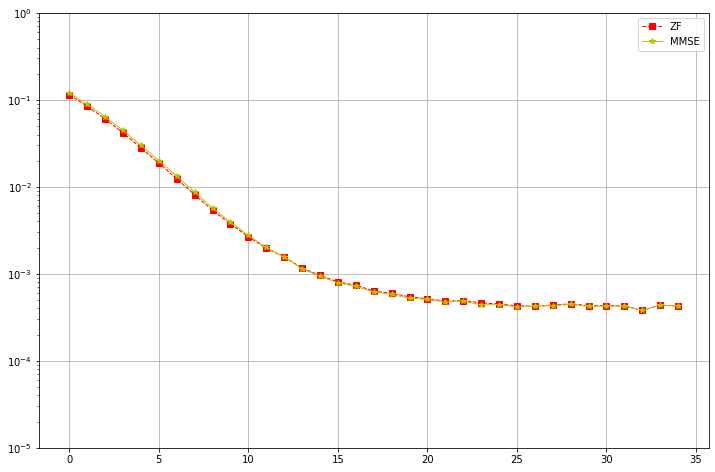

In [9]:

plt.figure(figsize=(12, 8))
plt.semilogy(sers_avg_zf, '--rs', linewidth=1, label='ZF')
plt.semilogy(sers_avg_mmse, '-y*', linewidth=1, label='MMSE') 
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.grid()
plt.legend()
plt.show()

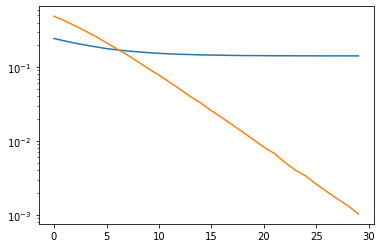

In [7]:
sers_avg_squeezed_loaded = np.load("./results/sers_avg_1_bit_zero_forcing.npy") 
sers_avg_real = np.load("./results/sers_avg_conventional_zero_forcing.npy")
plt.semilogy(sers_avg_squeezed_loaded / 100) 
plt.semilogy(sers_avg_real)
plt.show()

## Bussgang receiver

In [99]:
def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def symbol_by_symbol(x_tilde, constellation_points):
    compare = np.abs(x_tilde - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1) 
    x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)
    return x_hat 

def covr(H, snr):
    global N
    global T 
    if len(H.shape)>2:
        # return np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N))
        return np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N)) * np.ones(shape=(T, N, N))
    else:
        return np.matmul(H, (H.conjugate()).T) + (10**(-snr/20))*(np.eye(N) + 1j * np.eye(N)) 

def bussgang(H, snr):
    global N 
    Sigma_r = covr(H, snr)        # Sigma_r 
    diag_sigma = Sigma_r * ((np.eye(N)) * np.ones(shape=(T, N, N)))
    inv_diag_sigma = np.linalg.inv(diag_sigma) 
    sqrt_diag_sigma = np.sqrt(inv_diag_sigma)
    V = sqrt_diag_sigma * np.sqrt(2 / np.pi) 
    effective_channel = np.matmul(V, H) 

    ls = np.matmul(sqrt_diag_sigma, Sigma_r)
    rs1 = np.matmul(ls, sqrt_diag_sigma) * 0.9999
    ls = np.arcsin(rs1.real) + 1j * np.arcsin(rs1.imag)

    rs = rs1 - (10 ** (-snr / 20)) * np.linalg.inv(diag_sigma)
    effective_noise_covariance = np.sqrt(2 / np.pi) * (ls - rs)
    return effective_channel, effective_noise_covariance

In [81]:
Sigma_r = covr(H, snr)        # Sigma_r 
diag_sigma = Sigma_r * ((np.eye(N)) * np.ones(shape=(T, N, N)))
inv_diag_sigma = np.linalg.inv(diag_sigma) 
sqrt_diag_sigma = np.sqrt(inv_diag_sigma)
V = sqrt_diag_sigma * np.sqrt(2 / np.pi) 
effective_channel = np.matmul(V, H) 

ls = np.matmul(sqrt_diag_sigma, Sigma_r)
rs1 = np.matmul(ls, sqrt_diag_sigma)
# ls = np.arcsin(rs1.real) + 1j * np.arcsin(rs1.imag)

# rs = rs1 - (10 ** (-snr / 20)) * np.linalg.inv(diag_sigma)
# effective_noise_covariance = np.sqrt(2 / np.pi) * (ls - rs)



In [98]:
rs1 = np.matmul(np.matmul(sqrt_diag_sigma, Sigma_r), sqrt_diag_sigma) * 0.999
np.arcsin(rs1.real)

array([[[ 1.52607124,  0.79852528,  0.35581681, ..., -0.14199433,
         -0.42727242,  0.30445383],
        [ 0.79852528,  1.52607124,  0.30092031, ...,  0.15339155,
         -0.10438397, -0.11228519],
        [ 0.35581681,  0.30092031,  1.52607124, ..., -0.98976206,
         -0.97613917,  0.30729525],
        ...,
        [-0.14199433,  0.15339155, -0.98976206, ...,  1.52607124,
          0.96247925, -0.33817155],
        [-0.42727242, -0.10438397, -0.97613917, ...,  0.96247925,
          1.52607124, -0.50412764],
        [ 0.30445383, -0.11228519,  0.30729525, ..., -0.33817155,
         -0.50412764,  1.52607124]],

       [[ 1.52607124,  0.20141624, -0.37777622, ..., -0.79434708,
         -0.38007852, -0.67711991],
        [ 0.20141624,  1.52607124, -0.1515716 , ...,  0.46771056,
         -0.30706235, -0.21826721],
        [-0.37777622, -0.1515716 ,  1.52607124, ...,  0.15185077,
          0.09233134, -0.30027518],
        ...,
        [-0.79434708,  0.46771056,  0.15185077, ...,  

### 1. Initialize Hyperparameters 

- Number of users : `K` 
- Number of receive antennas : `N` 
- level of modulation (`M`-ary) : `M`
- Total transmission time : `T` 
- SNRs are in __dB__ scale 

In [63]:
K = 2 
N = 4
M = 4 
T = 10 
# dB scale
SNR_max = 30  
snr_single = 5 

### 2. Simple modulation scheme
    dependent on `M`
    

In [64]:
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

### 3. Symbol Space for ML-detection 

In [65]:
symbol_space = make_symbol_space(K, M, cp=constellation_points)
print("size of total symbols: ", symbol_space[:, 0].size)

size of total symbols:  16


### 4. generate symbols and Channel

In [66]:
x = np.random.randint(0, M, size=K*T).reshape(T, K, 1)
x = np.take(constellation_points, x) 

H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1)) 

r = np.matmul(H, x) + (10**(-snr_single/10)) * z 

### 5. pass 1-bit ADC receiver

In [67]:
y = np.sign(r.real) + 1j * (np.sign(r.imag))
print("after 1-bit ADC : Received(Real) --> Received(Quantized)")
for i, rs in enumerate(y[0]):
    print(f"Rx {i+1} : {r[0][i]} --> {y[0][i]}")

after 1-bit ADC : Received(Real) --> Received(Quantized)
Rx 1 : [0.21924104-0.27324729j] --> [1.-1.j]
Rx 2 : [0.96344029-0.28623477j] --> [1.-1.j]
Rx 3 : [-1.09409853-1.17060612j] --> [-1.-1.j]
Rx 4 : [-0.05349645-1.0087493j] --> [-1.-1.j]


### 6. Bussgang Decomposition - Linearization of Nonlinear operation

In [146]:
# dB scale
from operator import is_


snr = 5 
cov = np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10**(-snr/10)) * ((np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T,N,N)))
cov_r = covr(H, snr)

# for i in range(len(cov)):
#     print(is_pos_def(cov[0]), is_pos_def(cov[0].real), is_pos_def(cov[0].imag))
#     print(is_pos_def(cov_r[0]), is_pos_def(cov_r[0].real), is_pos_def(cov_r[0].imag))
#     print("---")

def nd_diag(mat):
    global T 
    size = mat.shape[1]
    return mat * ((np.eye(size)) * np.ones(shape=(T, size, size)))

diag_sigma_r = nd_diag(cov_r)
V_hat = np.sqrt(2 / np.pi) * np.sqrt(np.linalg.inv(diag_sigma_r))



In [51]:
# Check if a matrix is positive definite 
def is_pos_def(mat):
    return np.all(np.linalg.eigvals(mat) >= 0)

is_pos_def(e[0]), is_pos_def(e[0].real), is_pos_def(e[0].imag)

(True, True, False)

snr : -5  ser(bzf) : 1.169e-01    |    ser(bmmse) : 1.105e-01
snr : 0  ser(bzf) : 1.919e-02    |    ser(bmmse) : 1.770e-02
snr : 5  ser(bzf) : 1.850e-03    |    ser(bmmse) : 1.500e-03
snr : 10  ser(bzf) : 3.150e-04    |    ser(bmmse) : 2.150e-04
snr : 15  ser(bzf) : 1.150e-04    |    ser(bmmse) : 6.000e-05
snr : 20  ser(bzf) : 9.000e-05    |    ser(bmmse) : 3.500e-05
snr : 25  ser(bzf) : 7.500e-05    |    ser(bmmse) : 2.500e-05
snr : 30  ser(bzf) : 5.500e-05    |    ser(bmmse) : 1.000e-05


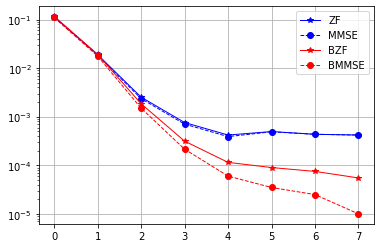

In [105]:
K = 2 
N = 16 
M = 4 
T = 100000
# dB scale
SNR_max = 30  
snr_single = 5 

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

sers = []
sers_mmse = []
sers_bzf = []
sers_bmmse = []

for snr in range(-5, SNR_max+5, 5):
    x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
    x = np.take(constellation_points, x)

    # Channel 
    H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
    z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

    r = np.matmul(H, x) + (10**(-snr/20)) * z 

    # Complex to real representation 
    H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

    # 1-bit ADC 
    y = np.sign(r_re) 
    y = y[:, :N, :] + 1j * y[:, N:, :]

    A, covn = bussgang(H, snr)

    # relaxed linear receiver 
    W_zf = np.linalg.pinv(H)
    W_mmse = np.matmul((H.conjugate()).transpose((0, 2, 1)), H) + (10**(-snr/20)) * ((np.eye(K)) * np.ones((T, K, K)))
    W_mmse = np.linalg.inv(W_mmse)
    W_mmse = np.matmul(W_mmse, (H.conjugate()).transpose((0, 2, 1)))
    W_bzf = np.linalg.pinv(A)
    W_bmmse = np.matmul(A, (A.conjugate()).transpose(0, 2, 1)) + covn 
    W_bmmse = np.linalg.inv(W_bmmse)
    W_bmmse = np.matmul((A.conjugate()).transpose(0, 2, 1), W_bmmse)
    # Relaxed estimation of x 

    x_tilde_zf = np.matmul(W_zf, y)
    x_tilde_mmse = np.matmul(W_mmse, y)
    x_tilde_bzf = np.matmul(W_bzf, y)
    x_tilde_bmmse = np.matmul(W_bmmse, y)
        
    # detection within each users (symbol-by-symbol)
    x_hat_zf = symbol_by_symbol(x_tilde=x_tilde_zf, constellation_points=constellation_points)
    x_hat_mmse = symbol_by_symbol(x_tilde=x_tilde_mmse, constellation_points=constellation_points) 
    x_hat_bzf = symbol_by_symbol(x_tilde=x_tilde_bzf, constellation_points=constellation_points)
    x_hat_bmmse = symbol_by_symbol(x_tilde=x_tilde_bmmse, constellation_points=constellation_points)

    # Compare 
    ser = 1-np.sum(np.isclose(x, x_hat_zf)) / (T * K)
    ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T * K)
    ser_bzf = 1-np.sum(np.isclose(x, x_hat_bzf)) / (T * K)
    ser_bmmse = 1-np.sum(np.isclose(x, x_hat_bmmse)) / (T * K)

    if snr % 5 == 0:
        # print("snr: ", snr, "ser (zf): ", ser, "  |  ser(mmse): ", ser_mmse, "  |  ser(bzf):", ser_bzf)
        print(f"snr : {snr}  ser(bzf) : {ser_bzf:.3e}    |    ser(bmmse) : {ser_bmmse:.3e}")
    sers.append(ser)
    sers_mmse.append(ser_mmse)
    sers_bzf.append(ser_bzf)
    sers_bmmse.append(ser_bmmse)



plt.figure()
plt.semilogy(sers, '-b*', linewidth=1, label='ZF') 
plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.semilogy(sers_bzf, '-r*', linewidth=1, label='BZF')
plt.semilogy(sers_bmmse, '--ro', linewidth=1, label="BMMSE")
plt.grid() 
plt.legend()
plt.show()



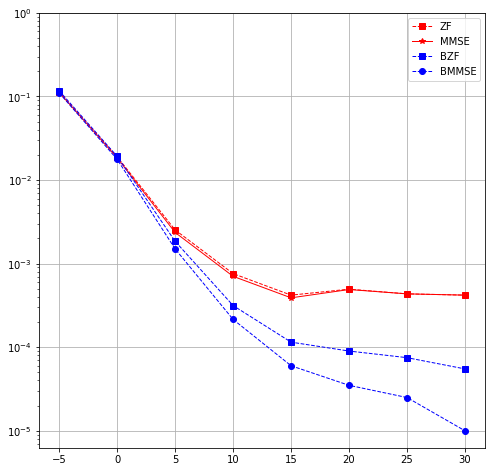

In [106]:

plt.figure(figsize=(8, 8))
plt.semilogy(range(-5, SNR_max+5, 5), sers, '--rs', linewidth=1, label='ZF')
plt.semilogy(range(-5, SNR_max+5, 5), sers_mmse, '-r*', linewidth=1, label='MMSE') 
plt.semilogy(range(-5, SNR_max+5, 5), sers_bzf, '--bs', linewidth=1, label='BZF')
plt.semilogy(range(-5, SNR_max+5, 5), sers_bmmse, '--bo', linewidth=1, label="BMMSE") 
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.grid()
plt.legend()
plt.show()

In [117]:
sers_avg_bmmse = np.load('./results/sers_avg_bmmse.npy') 
sers_avg_bmmse

array([1.1023125e-01, 1.7140875e-02, 1.6575000e-03, 2.2775000e-04,
       6.2125000e-05, 2.9875000e-05, 2.5875000e-05, 1.5750000e-05])

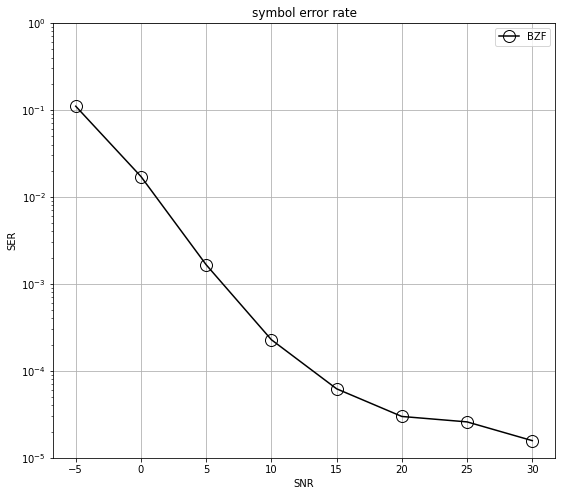

In [119]:

plt.figure(figsize=(9, 8))
plt.semilogy(np.arange(-5, 31, 5), sers_avg_bmmse, '-ko', label='BZF', markersize=12, fillstyle='none')

plt.grid()
plt.legend()
plt.xlabel("SNR")
plt.ylabel("SER")
plt.title("symbol error rate")
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.show()